In [1]:
#!/usr/bin/env python3
"""
Offset-free MPC (CT) migrated from `control/offset_free_CT.ipynb`.

- Loads A, B, C, trained Koopman-related modules, scalers, and sim setup
- Builds transformed representation with T_real
- Runs target estimation + MPC closed-loop simulation
- Saves plots under repository `figures/`
- Prints the objective line exactly as in the notebook:
  "Closed-loop objective function value: <value>"

Requires `src/helper` and `src/models` to be importable.
"""

from __future__ import annotations

import sys
from pathlib import Path
from typing import Tuple

import joblib
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

# Optional deps used in helper/model stack
import torch  # noqa: F401
import cvxpy as cp  # noqa: F401

# neuromancer symbols are imported in notebook; here they are required indirectly via helper/models loading
from neuromancer.modules import blocks  # type: ignore
from neuromancer.system import Node, System  # type: ignore
from neuromancer.problem import Problem  # type: ignore
from neuromancer.loss import PenaltyLoss  # type: ignore




In [2]:
# --------------------------- Repository paths ---------------------------------

def get_repo_root() -> Path:
    # In a notebook, __file__ is not defined; use cwd as a fallback
    return Path.cwd().resolve().parent


def get_figures_dir(repo_root: Path) -> Path:
    figures = repo_root / "figures"
    figures.mkdir(parents=True, exist_ok=True)
    return figures


# Ensure `src` is on PYTHONPATH
REPO_ROOT = get_repo_root()
SRC_PATH = REPO_ROOT / 'src'
if SRC_PATH.as_posix() not in sys.path:
    sys.path.append(SRC_PATH.as_posix())

import helper  # type: ignore
import models  # type: ignore


# ------------------------------ IO utilities ----------------------------------

def load_matrices_C_variant(data_dir: Path, matrix_C: bool) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    A = np.load((data_dir / f"A_C_{matrix_C}.npy").as_posix())
    B = np.load((data_dir / f"B_C_{matrix_C}.npy").as_posix())
    C = np.load((data_dir / f"C_C_{matrix_C}.npy").as_posix())
    return A, B, C


def load_scalers(data_dir: Path):
    scaler = joblib.load((data_dir / 'scaler.pkl').as_posix())
    scalerU = joblib.load((data_dir / 'scalerU.pkl').as_posix())
    return scaler, scalerU



# ------------------------------ CT helpers ------------------------------------

def build_encoders_decoders(ny: int, nz: int, nu: int, matrix_C: bool):
    layers = [40, 80, 120]
    layers_dec = [120, 80, 40]

    # output encoder f_y
    f_y = blocks.MLP(
        ny,
        nz,
        bias=True,
        linear_map=torch.nn.Linear,
        nonlin=torch.nn.ReLU,
        hsizes=layers,
    )
    encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
    encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

    # input encoder f_u representing B
    f_u = torch.nn.Linear(nu, nz, bias=False)
    encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

    # decoder
    if not matrix_C:
        f_y_inv = blocks.MLP(
            nz, ny, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU, hsizes=layers_dec
        )
    elif matrix_C:
        f_y_inv = torch.nn.Linear(nz, ny, bias=False)
    else:
        raise ValueError('matrix_C must be boolean')
    decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

    # Koopman linear K
    K = torch.nn.Linear(nz, nz, bias=False)
    Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

    dynamics_model = System([Koopman], name='Koopman', nsteps=1)
    nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]
    loss = PenaltyLoss([], constraints=[])
    problem = Problem(nodes, loss)
    return problem


def get_x_from_y(problem, y: np.ndarray) -> np.ndarray:
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1, -1).T


def get_y_from_x(problem, x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1, -1)





Helper imported succesfully
Models imported succesfully


In [3]:
data_dir = REPO_ROOT / 'data'
figures_dir = get_figures_dir(REPO_ROOT)

# Load matrices for matrix_C=False as in notebook
matrix_C = False
A, B, C = load_matrices_C_variant(data_dir, matrix_C)

nz, nu = B.shape
ny = C.shape[0]

# Disturbance model dimension
F = np.eye(ny)
nd = F.shape[1]

# Block diagonalization
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print("Close to block diagonal?", np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print("Backtransformation equals original A?", np.allclose(A, A_backtransformed, atol=1e-6))
# T_real = np.eye(nz)  # Use identity for now, as A is already block diagonal



Close to block diagonal? True
Backtransformation equals original A? True


In [4]:


# Apply transformation as in notebook (Cell 6)
A = inv(T_real) @ A @ T_real
B = inv(T_real) @ B
C = C @ T_real

# Koopman enc/dec + problem and load weights
problem = build_encoders_decoders(ny, nz, nu, matrix_C)
problem.load_state_dict(torch.load((data_dir / f'model_C_{matrix_C}.pth').as_posix()), strict=False)

# Load scalers
scaler, scalerU = load_scalers(data_dir)

# Plant model: use full nonlinear CSTR series with recycle for simulation
CSTR = models.CSTRSeriesRecycle()

# Sim setup
loaded_setup = joblib.load("sim_setup.pkl")


In [5]:

y_start = loaded_setup['y_start']
y_start_ns = loaded_setup.get('y_start_ns')
reference_ns = loaded_setup.get('reference_ns')
y_setpoint = loaded_setup['reference'][:, 0]
u_previous = loaded_setup['u_previous']
u_previous_ns = loaded_setup.get('u_previous_ns')

# Initial state estimate includes disturbance
z_est_ = np.hstack(((inv(T_real) @ get_x_from_y(problem, y_start)).T, np.zeros((1, nd))))

P0 = loaded_setup['P0']
Q = loaded_setup['Q']
R = loaded_setup['R']

A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)],
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu)),
])
C_ = np.hstack([
    C, np.eye(nd),
])

KF = helper.KF(A_, B_, C_, z_est_, P0, Q, R)



In [6]:
P0.shape

(30, 30)

In [7]:
z_est_[:, :]

array([[ 1.11649311, -1.9866544 ,  0.03547388,  1.23351288,  0.08466896,
         0.46477002, -0.26861033, -0.14765126, -0.75673997, -0.47548649,
         0.38166395, -1.25142527, -0.50092888, -0.10292964, -1.57386839,
        -1.03896677,  1.79722238,  0.16428119,  1.20993316, -0.88231629,
         0.20777065,  0.50675642,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [8]:
# Target calc
target_estimation = helper.TargetEstimation(A, B, C)
z_s, y_s = target_estimation.get_target(z_est_[:, nz:], y_setpoint)
z_ref = z_s


Set parameter Username
Set parameter LicenseID to value 2631450
Academic license - for non-commercial use only - expires 2026-03-05


In [9]:
# DIAGNOSTIC: Check consistency between encoder and C
print("=== Checking encoder vs C consistency ===")
z_from_encoder = (inv(T_real) @ get_x_from_y(problem, y_start)).T.flatten()
y_from_C = (C @ z_from_encoder).reshape(-1, 1)
y_start_reshaped = y_start.reshape(-1, 1)

print(f"y_start (measurement):        {y_start.flatten()}")
print(f"y from C (predicted):         {y_from_C.flatten()}")
print(f"Difference:                   {(y_start_reshaped - y_from_C).flatten()}")
print(f"Max abs difference:           {np.max(np.abs(y_start_reshaped - y_from_C))}")

print(f"\nInitial disturbance estimate:  {z_est_[:, nz:].flatten()}")
print(f"True initial error (should match KF correction): {(y_start_reshaped - y_from_C).flatten()}")


=== Checking encoder vs C consistency ===
y_start (measurement):        [ 1.46898584 -1.17565755  1.82098797 -1.30864812 -1.42006772 -1.48617731
 -1.18983342 -1.38329536]
y from C (predicted):         [ 1.6963652  -2.0079772   2.0567     -2.2348363  -0.9240523  -0.32326546
 -1.7609043  -1.8813497 ]
Difference:                   [-0.2273794   0.8323197  -0.23571202  0.92618822 -0.49601542 -1.16291185
  0.57107089  0.49805433]
Max abs difference:           1.1629118453747473

Initial disturbance estimate:  [0. 0. 0. 0. 0. 0. 0. 0.]
True initial error (should match KF correction): [-0.2273794   0.8323197  -0.23571202  0.92618822 -0.49601542 -1.16291185
  0.57107089  0.49805433]


In [10]:
y_s - y_setpoint

array([-0.12080134,  0.00345992, -0.16636718,  0.0226407 , -0.0150169 ,
       -0.15626221, -0.08193274, -0.06153515])

In [11]:
Qx = C.T@loaded_setup['Qy']@C + 1e-8 * np.eye(A.shape[0])

# is Qx psd?


In [12]:
Qx

array([[ 1.58572124e+00, -1.41564050e+00,  2.75817823e+00,
        -1.65968516e-01,  2.06275451e+00,  1.97621516e-01,
         1.99383713e-01, -2.03801716e+00,  1.22064297e-01,
         1.84342415e+00, -1.74619908e+00, -7.62344294e-01,
        -1.31616545e+00, -6.23284447e-01,  4.01159305e+00,
        -1.11690897e+00,  1.73892235e+00,  3.98878512e+00,
         1.40547696e+00,  6.25719176e-01,  5.35411419e-01,
        -8.49001244e-01],
       [-1.41564050e+00,  1.29359467e+01, -3.07906158e-02,
         5.60663439e-01,  1.03994798e+01, -1.38416989e+01,
         1.59137388e+01, -1.00924702e+01,  1.25649656e+00,
         3.55856071e+00, -3.01537876e+00,  2.77797842e+01,
        -3.16216232e+01, -1.20120251e+01,  2.44075692e+01,
        -2.16002390e+01,  1.55916527e+01,  3.24880032e+01,
        -8.04613064e+00, -2.38228501e+00, -1.47076759e+01,
         2.70822272e+01],
       [ 2.75817823e+00, -3.07906158e-02,  1.25044859e+01,
        -2.56295507e+00,  8.99913934e+00,  5.67366047e-01,
    

In [13]:
(C @ z_est_[:, :nz].T) >= loaded_setup['y_min'].reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [14]:
(C @ z_est_[:, :nz].T) <= loaded_setup['y_max'].reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [15]:

# MPC problem
mpc = helper.MPC(A, B, C)
_ = mpc.get_u_optimal(z_est_[:, :nz], z_est_[:, nz:], u_previous, z_ref)

# Closed-loop simulation
sim_time = int(loaded_setup['sim_time'])
Ts = 1

In [16]:


z_sim = np.zeros((nz + nd, sim_time + 1))
y_sim = np.zeros((ny, sim_time + 1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time + 1))
zs_sim = np.zeros((nz, sim_time + 1))

# Non-scaled histories for plant and evaluation (like NMPC)
y_sim_ns = np.zeros((ny, sim_time + 1))
u_sim_ns = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
if y_start_ns is not None:
    y_sim_ns[:, 0] = y_start_ns.flatten()
else:
    y_sim_ns[:, 0] = helper.np.asarray(scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]) if hasattr(helper, 'np') else scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
u_prev = target_estimation.u_s.value

if u_previous_ns is not None:
    u_sim_ns[:, 0] = u_previous_ns.flatten()
else:
    u_sim_ns[:, 0] = scalerU.inverse_transform(u_sim[:, 0].reshape(1, -1))[0]

for k in range(0, sim_time):
    idx_prev = max(k - 1, 0)        
    # Target update
    zs_sim[:, k], ys_sim[:, k] = target_estimation.get_target(
        z_sim[nz:, k], loaded_setup["reference"][:, k]
    )

    # MPC
    u_opt = mpc.get_u_optimal(z_sim[:nz, k], z_sim[nz:, k], u_prev, zs_sim[:, k])
    u_sim[:, k] = u_opt
    u_sim_ns[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1, -1))[0]

    # Plant
    y_sim_ns[:, k + 1] = CSTR.step(
        y_sim_ns[:, k], u_sim_ns[:, k].reshape(1, -1), Ts
    )
    # Scale for estimator/controller
    y_sim[:, k + 1] = scaler.transform(y_sim_ns[:, k + 1].reshape(1, -1))[0]

    # Estimation
    z_sim[:, k + 1] = KF.step(u_sim[:, k], y_sim[:, k + 1]).flatten()
    
    u_prev = u_sim[:, k]
reference = loaded_setup['reference']
# Compute objective in non-scaled units (like NMPC.py)



Disturbance statistics:
Initial disturbance: [0. 0. 0. 0. 0. 0. 0. 0.]
Final disturbance:   [-0.31799151  0.10858942 -0.16511175  0.21619243  0.47634183  0.47401344
  0.38107567  0.28013831]
Mean disturbance:    [-0.19732092  0.07224669 -0.06391898  0.20878232  0.35073476  0.34856593
  0.26226929  0.21235357]
Std disturbance:     [0.12166445 0.08673452 0.14229094 0.04562569 0.16735804 0.20860428
 0.08475019 0.08889354]


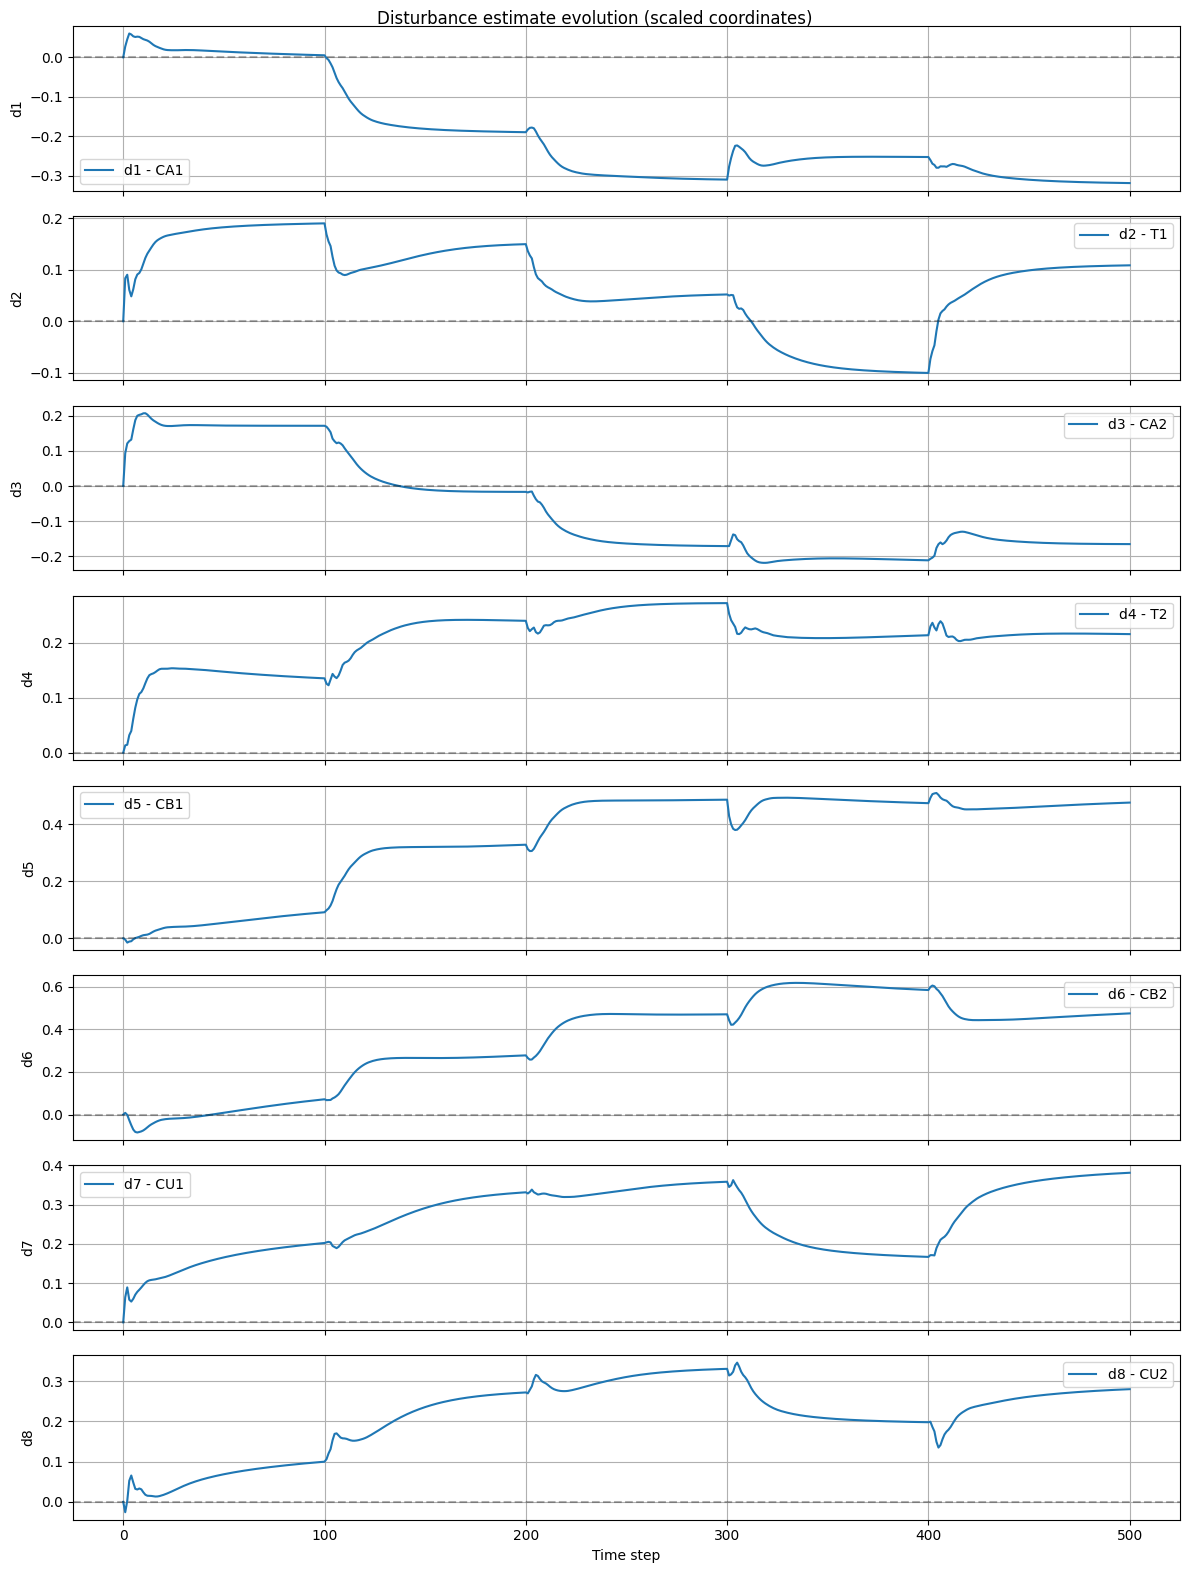

In [17]:
# DIAGNOSTIC: Analyze disturbance evolution
import matplotlib.pyplot as plt
fig_dist, axs_dist = plt.subplots(ny, 1, figsize=(12, 2*ny), sharex=True)
names = ['CA1','T1','CA2','T2','CB1','CB2','CU1','CU2']
for i in range(ny):
    axs_dist[i].plot(z_sim[nz+i, :], label=f'd{i+1} - {names[i]}')
    axs_dist[i].set_ylabel(f'd{i+1}')
    axs_dist[i].grid(True)
    axs_dist[i].legend()
    axs_dist[i].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axs_dist[-1].set_xlabel('Time step')
fig_dist.suptitle('Disturbance estimate evolution (scaled coordinates)')
plt.tight_layout()

print(f"\nDisturbance statistics:")
print(f"Initial disturbance: {z_sim[nz:, 0]}")
print(f"Final disturbance:   {z_sim[nz:, -1]}")
print(f"Mean disturbance:    {np.mean(z_sim[nz:, :], axis=1)}")
print(f"Std disturbance:     {np.std(z_sim[nz:, :], axis=1)}")


Closed-loop objective function value: 22.42246559268451
  - State tracking term: 21.582809375452015
  - Input increment term: 0.8396562172324911


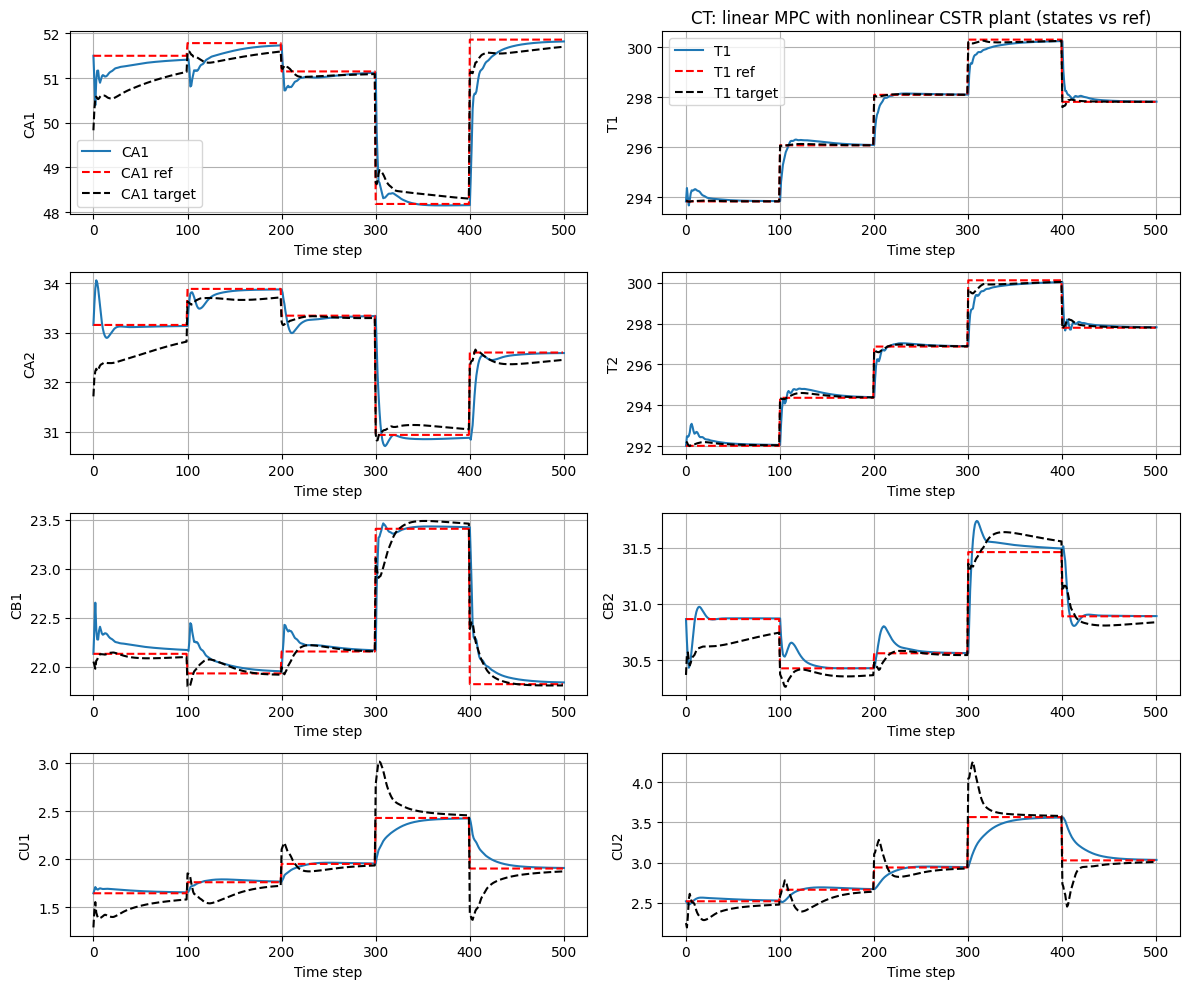

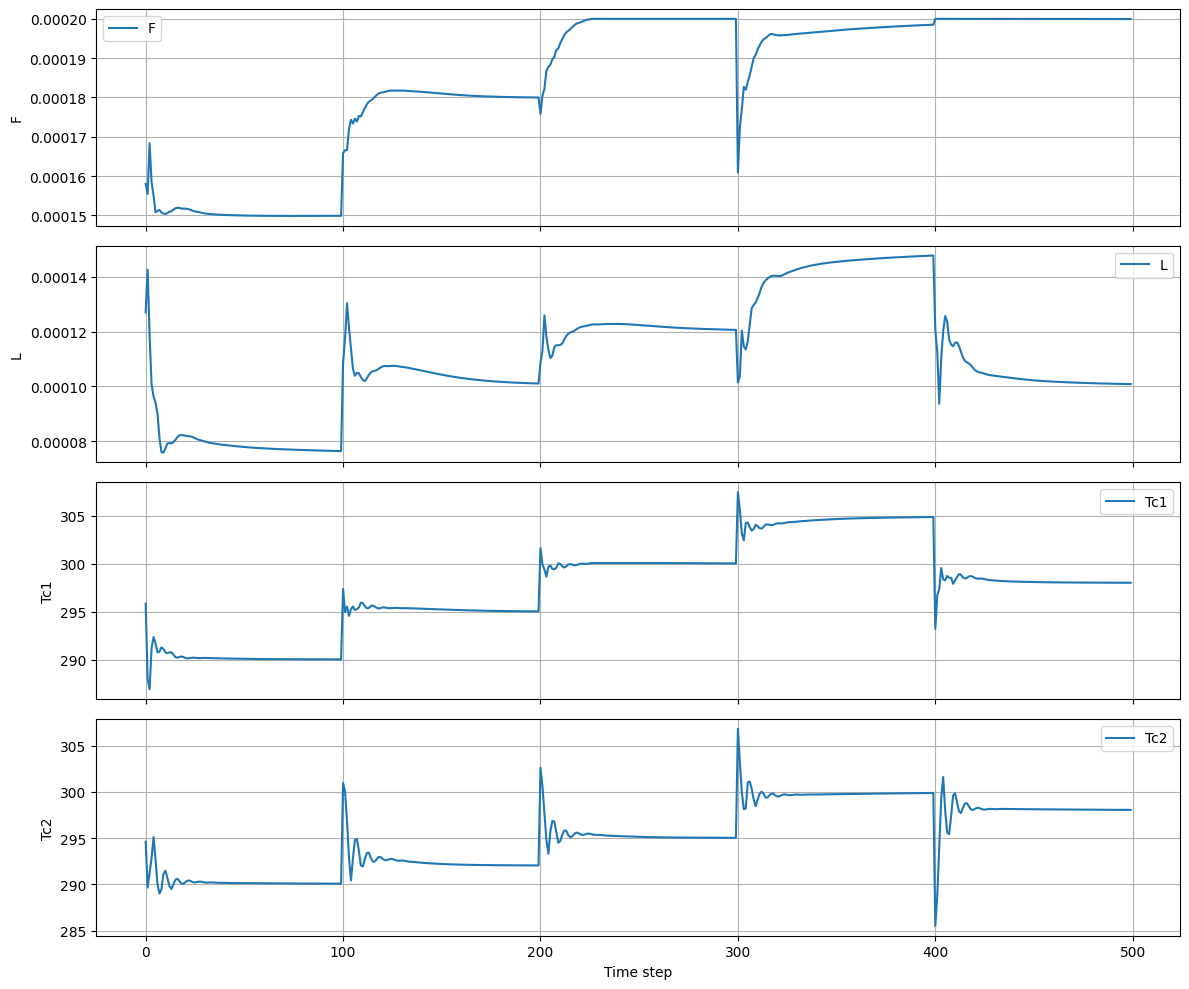

In [18]:
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
for k in range(sim_time):
    if reference is not None:
        y_ref_k = reference[:, k]
    else:
        y_ref_k = scaler.inverse_transform(loaded_setup['reference'][:, k].reshape(1, -1))[0]
    y_diff = y_sim[:, k] - y_ref_k
    prev_u = u_sim[:, k - 1] if k > 0 else u_sim[:, k]
    u_diff = u_sim[:, k] - prev_u
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qu @ u_diff)
    state_error_cost += y_term
    control_increment_cost += u_term
    objective_value += y_term + u_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input increment term: {control_increment_cost}")



# Plots saved to figures/ in non-scaled domain (8 states, 4 inputs)
ys_sim_ns = scaler.inverse_transform(ys_sim.T).T
zs_sim_ns = scaler.inverse_transform((C@zs_sim + z_sim[nz:]).T).T
z_sim_ns = scaler.inverse_transform((C@z_sim[:nz] + z_sim[nz:]).T).T
fig = plt.figure(figsize=(12, 10))
names = ['CA1','T1','CA2','T2','CB1','CB2','CU1','CU2']
n_steps = sim_time
for i in range(min(8, ny)):
    plt.subplot(4, 2, i+1)
    plt.plot(y_sim_ns[i, :], label=names[i] if i < len(names) else f'y{i}')
    if reference_ns is not None:
        plt.plot(reference_ns[i, :n_steps+1], 'r--', label=f'{names[i]} ref' if i < len(names) else f'y{i} ref')
    plt.plot(zs_sim_ns[i, :n_steps], 'k--', label=f'{names[i]} target')
    plt.xlabel('Time step')
    plt.ylabel(names[i] if i < len(names) else f'y{i}')
    plt.grid(True)
    if i in (0,1):
        plt.legend()
    if i == 1:
        plt.title('CT: linear MPC with nonlinear CSTR plant (states vs ref)')
plt.tight_layout()
fig.savefig((figures_dir / 'CT_states.png').as_posix(), dpi=200)


fig_inputs, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
input_names = ['F', 'L', 'Tc1', 'Tc2']
for i in range(4):
    axs[i].plot(u_sim_ns[i, :], label=input_names[i])
    axs[i].set_ylabel(input_names[i])
    axs[i].grid(True)
    axs[i].legend()
axs[-1].set_xlabel('Time step')
fig_inputs.tight_layout()


In [19]:
C@z_sim[:nz] + z_sim[nz:]

array([[ 1.69636533,  1.41867387,  1.37565158, ...,  1.49215594,
         1.49220006,  1.49224319],
       [-2.00797776, -1.14609693, -1.17484047, ..., -0.67287033,
        -0.67290268, -0.67293406],
       [ 2.05670002,  1.82683678,  1.88263027, ...,  1.75538977,
         1.75541211,  1.75543461],
       ...,
       [-0.32326567, -1.55276271, -1.60444371, ..., -1.4783713 ,
        -1.47836807, -1.47836542],
       [-1.76090386, -1.211929  , -1.19338645, ..., -1.12943329,
        -1.12945615, -1.12947788],
       [-1.88135051, -1.37592427, -1.40939323, ..., -1.2667417 ,
        -1.26677297, -1.26680306]])

In [20]:
scaler.inverse_transform((C@z_sim[:nz] + z_sim[nz:]).T).T

array([[ 54.63654534,  50.80375523,  50.2099473 , ...,  51.81797923,
         51.81858828,  51.81918357],
       [287.2239808 , 294.06889863, 293.84062207, ..., 297.82718758,
        297.82693061, 297.82668145],
       [ 35.20607061,  33.21193283,  33.69595941, ...,  32.59210694,
         32.5923008 ,  32.59249603],
       ...,
       [ 34.54977043,  30.65604058,  30.49237052, ...,  30.89163289,
         30.89164314,  30.89165153],
       [ -0.82536377,   1.55160234,   1.63188835, ...,   1.90879448,
          1.90869549,   1.90860138],
       [  0.32411649,   2.55094346,   2.40348461, ...,   3.03198436,
          3.03184662,   3.03171404]])